In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from torch_unet.dataset import TrainingSet, TestSet
from torch_unet.unet import UNet
import numpy as np

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split
import torch
import logging

import torch.nn as nn
from torch import optim
from tqdm import tqdm
from torch_unet.evaluation import eval_net
from torchsummary import summary
from torch_unet.losses import DiceCoeff

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
DATADIR = "../Datasets/training/"
IMAGE_DIR = DATADIR + "images/"
MASK_DIR = DATADIR + "groundtruth/"
MASK_THRESHOLD = 0.25

val_percent = 0.2
batch_size=1
lr = 0.01
img_scale = 1
epochs = 3

In [3]:
dataset = TrainingSet(IMAGE_DIR, MASK_DIR, mask_treshold=MASK_THRESHOLD)

n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

INFO: Creating dataset with 100 examples


In [4]:
# Register device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')
net = UNet(n_channels=3, n_classes=1, depth=3, padding=True)
net.to(device=device);

writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')
global_step = 0

INFO: Using device cpu


In [6]:
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-8)
criterion = nn.BCEWithLogitsLoss()

In [7]:
for epoch in range(epochs):
    net.train()   # Sets module in training mode
    epoch_loss = 0
    with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            imgs = batch['image']
            true_masks = batch['mask']

            imgs = imgs.to(device=device, dtype=torch.float32)
            true_masks = true_masks.to(device=device, dtype=torch.float32)
            
            masks_pred = net(imgs)  # Make predictions
            loss = criterion(masks_pred, true_masks)  # Evaluate loss

            epoch_loss += loss.item()    # Add loss to epoch
            writer.add_scalar('Loss/train', loss.item(), global_step)  

            pbar.set_postfix(**{'loss (batch)': loss.item()})

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.update(imgs.shape[0])
            global_step += 1
            if global_step % (len(dataset) // (10 * batch_size)) == 0:
                val_score = eval_net(net, val_loader, device, n_val)
                logging.info('Validation Dice Coeff: {}'.format(val_score))
                writer.add_scalar('Dice/test', val_score, global_step)

                writer.add_images('images', imgs, global_step)
                if net.n_classes == 1:
                    writer.add_images('masks/true', true_masks, global_step)
                    writer.add_images('masks/pred', torch.sigmoid(masks_pred) > 0.2, global_step)
writer.close()


Epoch 1/3:   2%|▎         | 2/80 [00:16<10:38,  8.19s/img, loss (batch)=47.7]


KeyboardInterrupt: 

In [5]:
test_set = TestSet("../Datasets/test_set_images/", 400/608)

INFO: Creating dataset with 50 examples


In [6]:
net.load_state_dict(state_dict=torch.load("../models/model_depth3_BS1_epochs100_lr0.001/final.pth", map_location=device))

<All keys matched successfully>

In [7]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

In [8]:
import matplotlib.image as mpimg

In [9]:
DEST_DIR = "../predictions/"

In [10]:
pred = torch.sigmoid(net(test_set[1]['image'][None, :, :, :])[0][0])

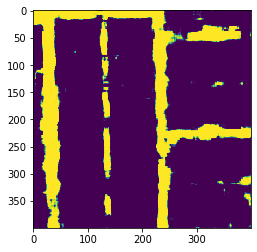

In [12]:
plt.imshow(pred.detach().numpy())

In [13]:
import cv2
from torch_unet.post_processing import post_process_prediction
for b in test_loader:
    preds = net(b['image'])
    
    img = (torch.sigmoid(preds)[0][0].detach().numpy() > 0.5) * 1
    img = cv2.resize(img.astype('uint8'), (608, 608), interpolation=cv2.INTER_LINEAR)
    #img = post_process_prediction(img)
    mpimg.imsave(DEST_DIR + b['id'][0] + ".png", img)

In [14]:
import pandas as pd

In [20]:
submission = pd.read_csv("../Datasets/submission.csv")
solution = pd.read_csv("../Datasets/solution.csv").rename(columns={'prediction': 'actual'}).drop(columns=['Usage'])

In [23]:
merged = submission.merge(solution, on='id')

In [24]:
merged.head()

,id,prediction,actual
0,001_0_0,0,0
1,001_0_16,0,1
2,001_0_32,0,1
3,001_0_48,1,1
4,001_0_64,1,0


In [27]:
tp = merged[(merged['actual'] == 1) & (merged['prediction'] == 1)].count()
fn = merged[(merged['actual'] == 1) & (merged['prediction'] == 0)].count()
fp = merged[(merged['actual'] == 0) & (merged['prediction'] == 1)].count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

In [28]:
f1_score

id            0.696873
prediction    0.696873
actual        0.696873
dtype: float64